In [18]:
# Web Scraping and Analysis of Job Postings
# Extracting job title, company, location, skills, and posted date


In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt


In [14]:
job_titles= ["Data Analyst",
"Python Developer",
"Data Scientist",
"BI Developer",
"Web Developer"]
companies = ["ABC Corp",
"XYZ Ltd",
"DataTech",
"BI Experts",
"WebWorks"]
locations = ["Karachi",
"Lahore",
"Islamabad",
"Karachi",
"Lahore"]
skills = ["8/1/2025",
"8/3/2025",
"8/5/2025",
"8/6/2025",
"8/7/2025"]
posted_dates = ["Python", "Excel", "SQL", "Power BI"
"Python", "Django", "REST API", "Git"
"Python", "Machine","Learning", "SQL"
"Power BI", "SQL", "Excel", "DAX"
"HTML", "CSS", "JavaScript", "React"]  # <-- NEW for posted date


In [13]:
# Cell 2 — quick info & missing values
df.info()
print("\nMissing values per column:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          5 non-null      object        
 1   company        5 non-null      object        
 2   location       5 non-null      object        
 3   date_posted    5 non-null      datetime64[ns]
 4   skills         5 non-null      object        
 5   __skills_list  5 non-null      object        
dtypes: datetime64[ns](1), object(5)
memory usage: 372.0+ bytes

Missing values per column:
 title            0
company          0
location         0
date_posted      0
skills           0
__skills_list    0
dtype: int64


In [4]:
# Cell 3 — normalize column names, strip whitespace
df.columns = df.columns.str.strip().str.lower()  # makes 'Date Posted' -> 'date_posted'
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)  # trim string cells

# parse dates (if parseable)
if 'date_posted' in df.columns:
    df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')

df.head()


C:\Users\Hp\AppData\Local\Temp\ipykernel_23920\2872017184.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)  # trim string cells


,title,company,location,date_posted,skills
0,Data Analyst,ABC Corp,Karachi,2025-08-01,"Python, Excel, SQL, Power BI"
1,Python Developer,XYZ Ltd,Lahore,2025-08-03,"Python, Django, REST API, Git"
2,Data Scientist,DataTech,Islamabad,2025-08-05,"Python, Machine Learning, SQL"
3,BI Developer,BI Experts,Karachi,2025-08-06,"Power BI, SQL, Excel, DAX"
4,Web Developer,WebWorks,Lahore,2025-08-07,"HTML, CSS, JavaScript, React"


In [5]:
# Cell 4 — normalize skills column into exploded table (one row per skill)
import re

# find skills column name
skill_col = None
for c in df.columns:
    if 'skill' in c:
        skill_col = c
        break

if not skill_col:
    raise ValueError("No skills column found. Columns: " + ", ".join(df.columns))

def normalize_skills(cell):
    if pd.isna(cell):
        return []
    if isinstance(cell, (list, tuple, set)):
        return [str(x).strip() for x in cell if str(x).strip()]
    s = str(cell).strip()
    if s == "":
        return []
    if s.startswith('[') and s.endswith(']'):
        s = s[1:-1]
    parts = re.split(r'[,\n;/\|]+', s)
    return [p.strip().strip('"\'' ) for p in parts if p.strip()]

# apply and explode
df['__skills_list'] = df[skill_col].apply(normalize_skills)
skills_df = df[['title','company','location','date_posted']].join(
    df['__skills_list'].explode().rename('skill')
).dropna(subset=['skill']).reset_index(drop=True)

# clean the skill text
skills_df['skill'] = skills_df['skill'].str.lower().str.strip()
skills_df = skills_df[skills_df['skill'] != ""]  # drop empties

# preview
skills_df.head(20)


,title,company,location,date_posted,skill
0,Data Analyst,ABC Corp,Karachi,2025-08-01,python
1,Data Analyst,ABC Corp,Karachi,2025-08-01,excel
2,Data Analyst,ABC Corp,Karachi,2025-08-01,sql
3,Data Analyst,ABC Corp,Karachi,2025-08-01,power bi
4,Python Developer,XYZ Ltd,Lahore,2025-08-03,python
5,Python Developer,XYZ Ltd,Lahore,2025-08-03,django
6,Python Developer,XYZ Ltd,Lahore,2025-08-03,rest api
7,Python Developer,XYZ Ltd,Lahore,2025-08-03,git
8,Data Scientist,DataTech,Islamabad,2025-08-05,python
9,Data Scientist,DataTech,Islamabad,2025-08-05,machine learning


In [6]:
# Cell 5 — count skills overall and save CSV + show top 20
skill_counts = skills_df['skill'].value_counts()
skill_counts.head(20)
# save
skill_counts.to_csv("skill_counts.csv", header=['count'])
print("Saved: skill_counts.csv")


Saved: skill_counts.csv


In [7]:
# Cell 6 — top job titles
title_counts = df['title'].str.strip().str.title().value_counts()
title_counts.head(15)


title
Data Analyst        1
Python Developer    1
Data Scientist      1
Bi Developer        1
Web Developer       1
Name: count, dtype: int64

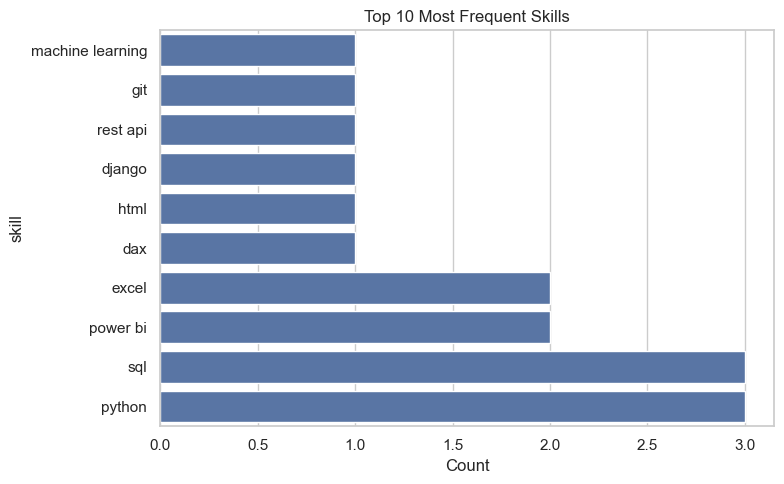

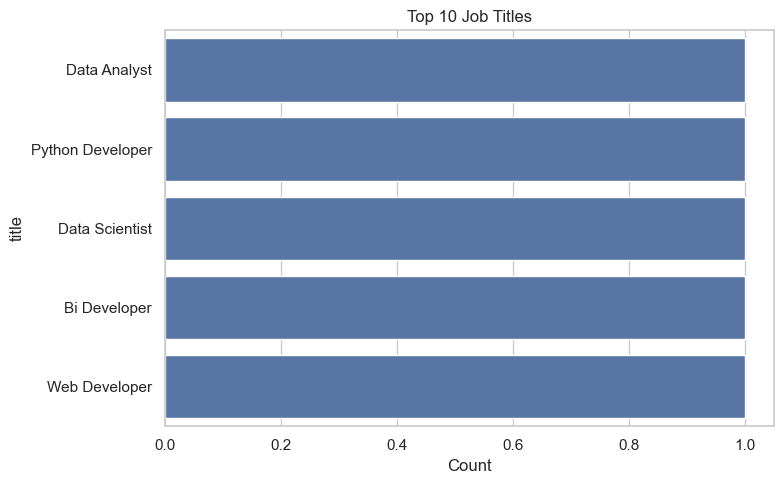

In [8]:
# Cell 7 — plots (matplotlib + seaborn)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
# Top 10 skills barh
top_skills = skill_counts.head(10).sort_values()
plt.figure(figsize=(8,5))
sns.barplot(x=top_skills.values, y=top_skills.index)
plt.title("Top 10 Most Frequent Skills")
plt.xlabel("Count")
plt.tight_layout()
plt.savefig("top_skills.png")
plt.show()

# Top 10 job titles
top_titles = title_counts.head(10).sort_values()
plt.figure(figsize=(8,5))
sns.barplot(x=top_titles.values, y=top_titles.index)
plt.title("Top 10 Job Titles")
plt.xlabel("Count")
plt.tight_layout()
plt.savefig("top_titles.png")
plt.show()


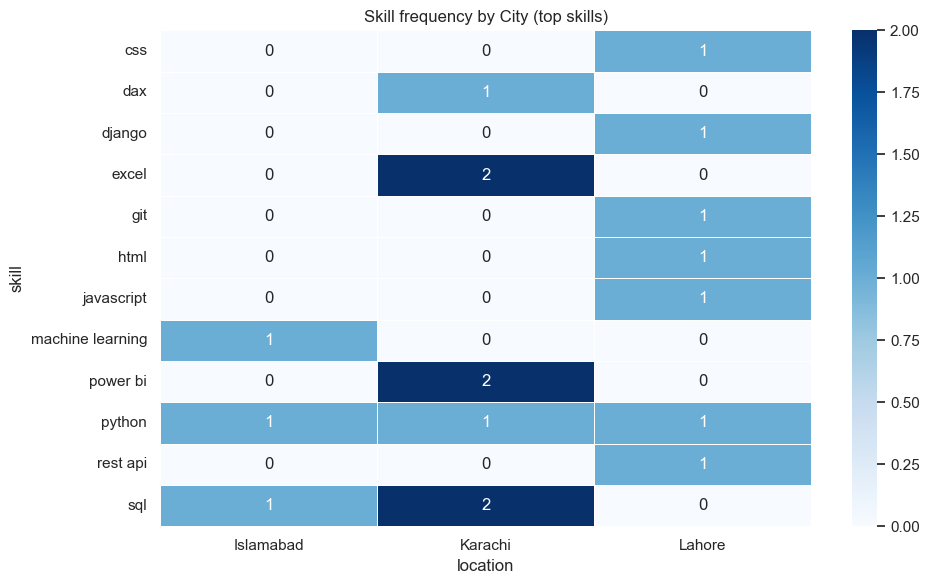

Saved: skills_by_city_pivot.csv and skills_by_city_heatmap.png


In [9]:
# Cell 8 — group by location + skill and produce a pivot table
city_skill = skills_df.groupby(['location','skill']).size().reset_index(name='count')

# pivot for a heatmap (cities as columns, top skills as rows)
pivot = city_skill.pivot(index='skill', columns='location', values='count').fillna(0)

# pick top K skills overall to keep plot readable
top_k = skill_counts.head(12).index.tolist()
pivot_top = pivot.loc[pivot.index.isin(top_k)]

# heatmap
plt.figure(figsize=(10,6))
sns.heatmap(pivot_top, annot=True, fmt=".0f", linewidths=.5, cmap='Blues')
plt.title("Skill frequency by City (top skills)")
plt.tight_layout()
plt.savefig("skills_by_city_heatmap.png")
plt.show()

# Also save pivot to CSV for reporting
pivot_top.to_csv("skills_by_city_pivot.csv")
print("Saved: skills_by_city_pivot.csv and skills_by_city_heatmap.png")


In [10]:
# Cell 9 — save cleaned (expanded) dataset and a version of cleaned main df
skills_df.to_csv("job_postings_skills_exploded.csv", index=False)
df.to_csv("job_postings_cleaned.csv", index=False)
print("Saved: job_postings_skills_exploded.csv and job_postings_cleaned.csv")


Saved: job_postings_skills_exploded.csv and job_postings_cleaned.csv
